# setup

In [2]:
# Install the PyTorch version of the timesfm library
!pip install timesfm[torch]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.

In [54]:
import os
import torch
import time
import numpy as np
import pandas as pd
import math
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import timesfm

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

path = '/content/drive/MyDrive/dev/'

Mounted at /content/drive/


In [5]:
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")

In [6]:
if torch.cuda.is_available():
    !nvcc --version

In [7]:
if torch.cuda.is_available():
    !nvidia-smi

# model

In [9]:
# Initialize the TimesFm model
tfm = timesfm.TimesFm(
    hparams=timesfm.TimesFmHparams(
        backend="cpu",  # Use "gpu" if a GPU runtime is selected
        context_len=CONTEXT_LEN,
        horizon_len=HORIZON_LEN,
        # The following parameters are fixed for the 2.0-500m model
        input_patch_len=32,
        output_patch_len=128,
        num_layers=50,
        model_dims=1280,
        use_positional_embedding=False,
    ),
    checkpoint=timesfm.TimesFmCheckpoint(
        huggingface_repo_id="google/timesfm-2.0-500m-pytorch"
    ),
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

.gitattributes: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/692 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

torch_model.ckpt:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

# data

In [48]:
# Load World M2 (wm2) and Bitcoin (btc) data
data_path = path+"sapheneia/github/sapheneia/data/"
btc  = pd.read_csv(data_path+"btc.csv")
wm2 = pd.read_csv(data_path+"wm2.csv")

In [49]:
# Define the horizon for computation of log returns in each time-series
# Given the use case of BTC and WM2 and that WM2 is given in weeks, the number of periods for horizon will be in weeks
logreturn_horizon = 1

In [50]:
# Convert 'Date' column in btc to datetime objects
btc['Date'] = pd.to_datetime(btc['Date'])

# Convert 'observation_date' column in wm2 to datetime objects
wm2['observation_date'] = pd.to_datetime(wm2['observation_date'])

# Merge the two dataframes on the date columns
data = pd.merge(btc, wm2, left_on='Date', right_on='observation_date', how='inner')
data = data[['Date','Close','WM2NS']]
data = data.rename(columns={'Date': 'date','Close': 'btc','WM2NS': 'wm2'})

# Display the first few rows of the merged dataframe
display(data.head())

,date,btc,wm2
0,2014-04-21,495.16,11355.4
1,2014-04-28,441.92,11231.2
2,2014-05-05,430.87,11285.3
3,2014-05-12,438.21,11286.0
4,2014-05-19,443.90,11278.4


In [51]:
# prompt: Using dataframe data: Compute a column for each btc and wm2 with the changes from one period to another. Change here is defined as log(x_2,x_1) where x_2 is the value of the column in a period ahead of the value x_1, where the number of periods between x_2 and x_1 is defined by a parameter horizon. Start with the first x_1 as the first period in the dataframe.

# Calculate the log change for 'btc'
data['btc_logreturn'] = np.log(data['btc'] / data['btc'].shift(logreturn_horizon))

# Calculate the log change for 'wm2'
data['wm2_logreturn'] = np.log(data['wm2'] / data['wm2'].shift(logreturn_horizon))

# prompt: Using dataframe data: Now given btc_change and wm2_change, first clean up rows NaN.

# Clean up rows with NaN values in 'btc_change' or 'wm2_change'
data.dropna(subset=['btc_logreturn', 'wm2_logreturn'], inplace=True)

# Round btc_change and wm2_change to 4 decimal places
data['btc_logreturn'] = data['btc_logreturn'].round(4)
data['wm2_logreturn'] = data['wm2_logreturn'].round(4)

# Sort by date to ensure calculations are in chronological order
data.sort_values(by='date', inplace=True)

# Display the first few rows of the merged dataframe
display(data.head())

,date,btc,wm2,btc_logreturn,wm2_logreturn
1,2014-04-28,441.92,11231.2,-0.1138,-0.0110
2,2014-05-05,430.87,11285.3,-0.0253,0.0048
3,2014-05-12,438.21,11286.0,0.0169,0.0001
4,2014-05-19,443.90,11278.4,0.0129,-0.0007
5,2014-05-26,582.01,11251.3,0.2709,-0.0024


In [52]:
series_a = data['wm2'].tolist()
print(series_a)

[11231.2, 11285.3, 11286.0, 11278.4, 11251.3, 11345.1, 11363.4, 11380.3, 11290.0, 11343.1, 11426.4, 11423.3, 11393.9, 11364.3, 11461.6, 11431.4, 11442.5, 11383.5, 11442.4, 11495.9, 11516.0, 11436.8, 11451.4, 11556.2, 11556.7, 11570.3, 11525.4, 11574.6, 11621.4, 11643.2, 11580.5, 11668.9, 11725.5, 11765.8, 11784.7, 11799.9, 11830.1, 11807.0, 11762.9, 11687.2, 11788.6, 11822.0, 11864.8, 11850.4, 11927.6, 11956.1, 11988.2, 11933.3, 11970.5, 12122.2, 12100.8, 12043.8, 11862.5, 11907.6, 11914.4, 11928.6, 11882.7, 11941.8, 11980.2, 11996.0, 11940.3, 11958.2, 12091.4, 12045.8, 12010.7, 11960.7, 12045.2, 12073.7, 12107.6, 12051.8, 12087.0, 12170.8, 12196.8, 12142.7, 12084.0, 12180.8, 12170.7, 12177.6, 12143.2, 12260.4, 12303.0, 12334.7, 12281.7, 12316.0, 12380.4, 12417.7, 12472.4, 12464.1, 12496.9, 12552.2, 12508.6, 12423.3, 12466.0, 12478.4, 12545.5, 12532.0, 12559.9, 12658.1, 12681.9, 12684.6, 12735.0, 12825.3, 12839.9, 12850.9, 12693.8, 12710.3, 12731.5, 12748.3, 12701.8, 12689.6, 12802.7, 

In [53]:
series_b = data['btc'].tolist()
print(series_b)

[441.92, 430.87, 438.21, 443.9, 582.01, 655.49, 644.35, 599.08, 591.17, 635.14, 613.6, 618.32, 625.13, 587.93, 592.77, 575.89, 462.18, 502.93, 477.19, 475.69, 477.71, 404.09, 376.77, 331.55, 387.32, 380.39, 350.09, 324.24, 367.15, 384.69, 378.85, 378.61, 364.95, 345.37, 330.84, 314.12, 274.84, 269.33, 215.87, 269.18, 238.86, 220.34, 235.83, 238.82, 273.75, 290.02, 290.41, 265.46, 246.79, 254.97, 223.59, 224.24, 228.96, 238.97, 241.81, 232.64, 237.41, 223.14, 228.57, 237.0, 247.46, 256.97, 269.08, 290.35, 277.68, 293.01, 281.58, 263.3, 257.13, 211.43, 229.47, 239.58, 229.91, 226.33, 238.87, 240.15, 245.35, 263.82, 285.15, 359.28, 380.22, 330.21, 322.12, 377.97, 394.28, 442.0, 437.59, 421.76, 433.32, 447.72, 384.4, 392.76, 372.18, 372.63, 401.07, 437.79, 436.21, 414.87, 414.31, 411.11, 422.21, 419.33, 421.43, 427.69, 461.73, 444.18, 460.44, 454.87, 443.69, 532.26, 583.58, 700.07, 733.97, 644.66, 675.16, 646.71, 670.38, 654.0, 607.0, 589.24, 566.95, 587.47, 574.23, 605.76, 607.98, 609.85,

In [ ]:
len(data)

576

# experiments

## (1) basic with synthetic data (sine + noise)

In [36]:
# Define parameters for the synthetic data
CONTEXT_LEN = 512
HORIZON_LEN = 128

# Create a synthetic time-series: a sine wave with noise
# context_data = np.sin(np.linspace(0, 40, CONTEXT_LEN)) + np.random.randn(CONTEXT_LEN) * 0.1
time = np.arange(CONTEXT_LEN)
context_data = np.sin(time * 0.1) + np.sin(time * 0.25) + np.random.randn(len(time)) * 0.5

# The input for the forecast function must be a list of numpy arrays
forecast_input = [context_data]

In [37]:
# Run the forecast
# The `freq` input is a list of integers corresponding to the input series.
# 0 = high frequency (e.g., daily), 1 = medium (e.g., weekly), 2 = low (e.g., yearly)
point_forecast, experimental_quantile_forecast = tfm.forecast(
    forecast_input,
    freq=[0],
)

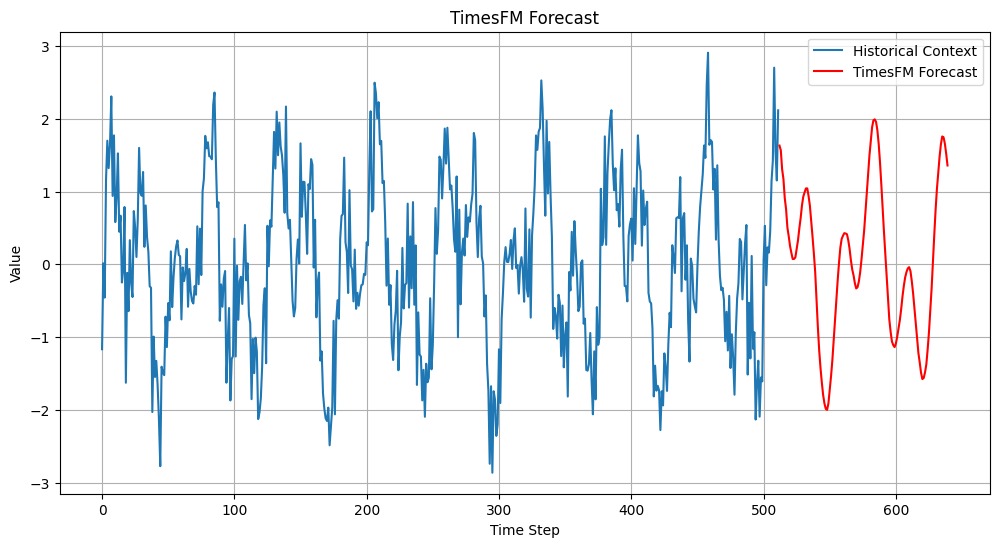

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Assume CONTEXT_LEN and HORIZON_LEN are defined in your environment
# Assume context_data and point_forecast already exist from your previous steps

plt.figure(figsize=(12, 6))

# Plot the historical data that the model used as input
plt.plot(np.arange(CONTEXT_LEN), context_data, label="Historical Context")

# Plot the forecasted data
# The forecast starts at the end of the context
forecast_horizon = np.arange(CONTEXT_LEN, CONTEXT_LEN + HORIZON_LEN)

# By using point_forecast[0], we select the 1D array from the 2D batch, fixing the error.
plt.plot(forecast_horizon, point_forecast[0], color='red', label="TimesFM Forecast")

# --- Formatting ---
plt.title("TimesFM Forecast")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [40]:
experimental_quantile_forecast, experimental_quantile_forecast.shape

(array([[[1.6372994 , 0.97508764, 1.2086987 , ..., 1.8921614 ,
          2.0586965 , 2.2899003 ],
         [1.563626  , 0.91982067, 1.1454911 , ..., 1.8298789 ,
          1.9912821 , 2.2194676 ],
         [1.2992289 , 0.6749248 , 0.9049376 , ..., 1.5630562 ,
          1.72939   , 1.9533336 ],
         ...,
         [1.6579363 , 1.0440068 , 1.252825  , ..., 1.9105881 ,
          2.061696  , 2.2735317 ],
         [1.521943  , 0.929659  , 1.124909  , ..., 1.7821602 ,
          1.9227628 , 2.134675  ],
         [1.3501425 , 0.75629103, 0.96000123, ..., 1.6085737 ,
          1.7618796 , 1.972828  ]]], dtype=float32),
 (1, 128, 10))

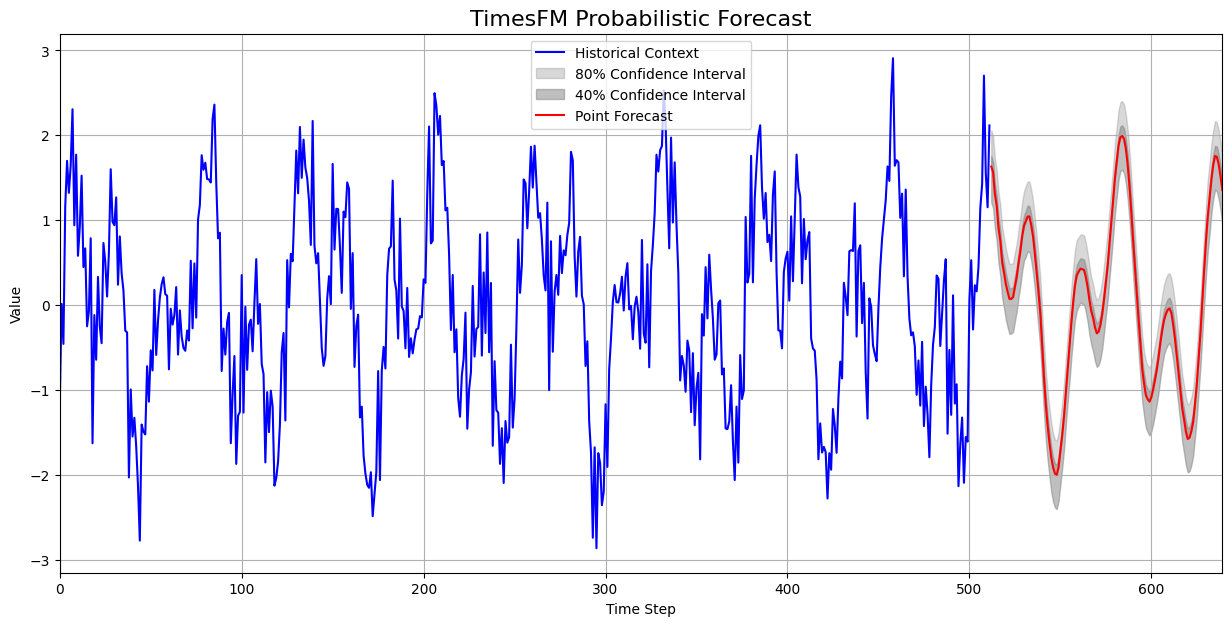

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Assume CONTEXT_LEN and HORIZON_LEN are defined in your environment
# Assume context_data, point_forecast, and experimental_quantile_forecast already exist

plt.figure(figsize=(15, 7))

# 1. Plot the historical data that the model used as input
plt.plot(np.arange(CONTEXT_LEN), context_data, 'b-', label="Historical Context")

# Define the x-axis for the forecast period
forecast_horizon = np.arange(CONTEXT_LEN, CONTEXT_LEN + HORIZON_LEN)

# 2. Extract and plot the quantile forecasts to create the "cloud"
# First, get the forecast batch (index 0) from the quantile data
quantile_forecasts_1d = experimental_quantile_forecast[0]

# Plot the 80% confidence interval (between 0.1 and 0.9 quantiles)
plt.fill_between(
    forecast_horizon,
    quantile_forecasts_1d[:, 0], # 0.1 quantile at index 0
    quantile_forecasts_1d[:, 8], # 0.9 quantile at index 8
    color='gray',
    alpha=0.3,
    label='80% Confidence Interval'
)

# Plot the 40% confidence interval (between 0.3 and 0.7 quantiles)
plt.fill_between(
    forecast_horizon,
    quantile_forecasts_1d[:, 2], # 0.3 quantile at index 2
    quantile_forecasts_1d[:, 6], # 0.7 quantile at index 6
    color='gray',
    alpha=0.5,
    label='40% Confidence Interval'
)

# 3. Plot the main point forecast
# We use point_forecast[0] to select the 1D array from the 2D batch
plt.plot(forecast_horizon, point_forecast[0], 'r-', label="Point Forecast")


# --- Formatting ---
plt.title("TimesFM Probabilistic Forecast", fontsize=16)
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.show()

## (2) BTC data without covariate

### def

In [ ]:
def normalize_data(data, context_length=None, horizon_length=None):

    context = data
    if (horizon_length is not None) and (horizon_length<len(data)):
        context = data[:-horizon_length]

    context_reshaped = context.reshape(-1, 1)

    # Fit a StandardScaler to the raw data
    context_scaler = StandardScaler()
    context_scaler.fit(context_reshaped)

    # Standardize the data (mean=0, std=1)
    a_logreturns_reshaped = a_logreturns.reshape(-1, 1)
    a_standardized = a_scaler.transform(a_logreturns_reshaped)

    return

### experiment

In [ ]:
CONTEXT_LENGTH = 512
HORIZON_LENGTH = 128

In [55]:
data

,date,btc,wm2,btc_logreturn,wm2_logreturn
1,2014-04-28,441.920,11231.2,-0.1138,-0.0110
2,2014-05-05,430.870,11285.3,-0.0253,0.0048
3,2014-05-12,438.210,11286.0,0.0169,0.0001
4,2014-05-19,443.900,11278.4,0.0129,-0.0007
5,2014-05-26,582.010,11251.3,0.2709,-0.0024
...,...,...,...,...,...
572,2025-04-07,79143.063,22081.1,-0.0420,0.0049
573,2025-04-14,84575.750,22113.7,0.0664,0.0015
574,2025-04-21,87515.570,21935.8,0.0342,-0.0081
575,2025-04-28,95035.063,21779.0,0.0824,-0.0072
